In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba.core import types
import os

# Util functions for the Simulated Annealing

- most of them were available/coded in the assignment docs

In [2]:
@jit(nopython=True)
def newpath(cam, dist):
    N = len(cam)
    ncam = np.zeros(N, dtype=np.int16)

    # Seleciona i e j aleatoriamente de forma que i ≠ j
    i = np.random.randint(N)
    j = i
    while j == i:
        j = np.random.randint(N)
    
    # Define ini e fim de forma que ini < fim
    if i > j:
        ini = j
        fim = i
    else:
        ini = i
        fim = j

    # Cria o novo caminho ncam baseado em cam
    for k in range(N):
        if ini <= k <= fim:
            ncam[k] = cam[fim - (k - ini)]
        else:
            ncam[k] = cam[k]

    # Calcula as diferenças nas extremidades do intervalo
    esq = ini - 1
    if esq < 0:
        esq = N - 1
    dir = fim + 1
    if dir > N - 1:
        dir = 0

    de = (-dist[cam[esq], cam[ini]] - dist[cam[dir], cam[fim]] 
          + dist[ncam[esq], ncam[ini]] + dist[ncam[dir], ncam[fim]])

    return ncam, de

#define a distancia entre duas cidades quaisquer
@jit(nopython=True)
def distances(N,x,y):
    
    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j]))
            
    return dist

@jit(nopython=True)
def cost(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    ener += dist[path[0],path[N-1]]     # conecta a última e a primeira cidades do caminho
    
    return ener

# Plot functions

In [3]:
from manim import *

class TSPPlot(Scene):
    def __init__(self, X, Y, path, cost, temp, save=False, save_path='graphs', filename=None, **kwargs):
        self.X = X
        self.Y = Y
        self.path = path
        self.cost = cost
        self.temp = temp
        self.save = save
        self.save_path = save_path
        self.filename = filename
        super().__init__(**kwargs)

    def construct(self):
        # Create points
        points = [Dot([x, y, 0], color=BLUE) for x, y in zip(self.X, self.Y)]

        # Create path
        edges = []
        for i in range(len(self.path)):
            start = self.path[i]
            end = self.path[(i + 1) % len(self.path)]
            edge = Line(points[start].get_center(), points[end].get_center(), color=RED)
            edges.append(edge)

        # Add points and edges to the scene
        self.add(*points)
        self.add(*edges)

        # Add annotations
        for i, point in enumerate(points):
            label = Text(str(i), font_size=24).next_to(point, DOWN)
            self.add(label)

        # Add title
        title = Text(f'TSP path - cost: {self.cost} - temperature: {self.temp}', font_size=24)
        title.to_edge(UP)
        self.add(title)

        if self.save:
            if not os.path.exists(self.save_path):
                os.makedirs(self.save_path)
            
            if self.filename is None:
                self.filename = f'tsp_path_cost_{round(self.cost, 5)}_temp_{self.temp}.mp4'
            
            self.save_path = os.path.join(self.save_path, self.filename)
            self.embed_movie(self.save_path)


In [4]:
def plot_tsp(X, Y, path, cost, temp, save=False, save_path='graphs', filename=None):
    plt.figure(figsize=(8, 6))
    
    plt.scatter(X, Y, color='blue')
    
    for i in range(len(path)):
        start = path[i]
        end = path[(i + 1) % len(path)]
        plt.plot([X[start], X[end]], [Y[start], Y[end]], 'r-')
    
    # Annotate the points
    for i, (x, y) in enumerate(zip(X, Y)):
        plt.text(x, y, f'{i}', fontsize=10, ha='right')
    
    plt.title(f'TSP path - cost: {cost} - temperature: {temp}')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.grid(True)
    
    if save:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        if filename is None:
            filename = f'tsp_path_cost_{np.round(cost, 5)}_temp_{temp}.png'
        
        plt.savefig(os.path.join(save_path, filename))
        plt.close()
        
    else:
        plt.show()
    

def plot_tsp_side_by_side(X, Y, method_name1, path1, cost1, method_name2, path2, cost2):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # First plot
    axs[0].scatter(X, Y, color='blue')
    for i in range(len(path1)):
        start = path1[i]
        end = path1[(i + 1) % len(path1)]
        axs[0].plot([X[start], X[end]], [Y[start], Y[end]], 'r-')
    for i, (x, y) in enumerate(zip(X, Y)):
        axs[0].text(x, y, f'{i}', fontsize=12, ha='right')
    axs[0].set_title(f'{method_name1} - cost: {np.round(cost1, 4)}')
    axs[0].set_xlabel('X Coordinates')
    axs[0].set_ylabel('Y Coordinates')
    axs[0].grid(True)

    # Second plot
    axs[1].scatter(X, Y, color='blue')
    for i in range(len(path2)):
        start = path2[i]
        end = path2[(i + 1) % len(path2)]
        axs[1].plot([X[start], X[end]], [Y[start], Y[end]], 'r-')
    for i, (x, y) in enumerate(zip(X, Y)):
        axs[1].text(x, y, f'{i}', fontsize=12, ha='right')
    axs[1].set_title(f'{method_name2} - cost: {np.round(cost2, 4)}')
    axs[1].set_xlabel('X Coordinates')
    axs[1].set_ylabel('Y Coordinates')
    axs[1].grid(True)

    plt.show()

# Simulated Annealing main function

In [5]:
@jit(nopython=True)
def simulated_annealing(
    config: numba.typed.Dict,
    N: int,
    x: np.ndarray,
    y: np.ndarray,
    inipath: np.ndarray,
    plot=False) -> tuple[np.array, float]:
    """
    Executes the simulated annealing algorithm in a 2d space to solve TSP.
    
    Args:
        config (numba.typed.Dict):
            This config dict must be numba integrated, that's why the type
            it must have the keys:
            - 'T': initial temperature,
            - 'dT': decaying temperature factor,
            - 'Tf': final minimum temperature,
            - 'steps': steps for monte carlo in the same temperature,
            - 'iterations': number of iterations of monte carlos batches,
        
        N (int): number of cities
        x (np.ndarray): x values array
        y (np.ndarray): y values array
        inipath (np.ndarray): initial path
        
    Returns:
        (best_path, best_cost): best path and cost encountered during the execution
    """
    
    # Initialization
    distance_matrix = distances(N, x, y)
    temp = config['T']
    
    current_path = inipath.copy()
    current_cost = -1
    
    best_path = current_path
    best_cost = np.inf
    
    # Repeat process
    for _ in range(config['iterations']):
        # Monte Carlo Simmulations
        for _ in range(config['steps']):
            new_path, de = newpath(current_path, distance_matrix)
            
            if de < 0:
                current_path = new_path
                current_cost = cost(N, current_path, distance_matrix)
            else:
                if np.random.rand() <= np.exp(-de / temp):
                    current_path = new_path
                    current_cost = cost(N, current_path, distance_matrix)
                    
            if current_cost < best_cost:
                best_cost = current_cost
                best_path = current_path.copy()
                    
        temp = max(temp * config['dT'], config['Tf'])
    
    return best_path, best_cost

# Nearest Neighbors solution for TSP for comparation

In [6]:
@jit(nopython=True)
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

@jit(nopython=True)
def nearest_neighbor(x, y, start_city):
    N = len(x)
    visited = np.zeros(N, dtype=np.int32)
    path = np.zeros(N, dtype=np.int32)
    current_city = start_city
    path[0] = current_city
    visited[current_city] = 1
    total_cost = 0.0

    for i in range(1, N):
        nearest_city = -1
        nearest_distance = np.inf
        for j in range(N):
            if not visited[j]:
                dist = distance(x[current_city], y[current_city], x[j], y[j])
                if dist < nearest_distance:
                    nearest_distance = dist
                    nearest_city = j
        path[i] = nearest_city
        visited[nearest_city] = 1
        total_cost += nearest_distance
        current_city = nearest_city
    
    # Return to the start city to complete the cycle
    total_cost += distance(x[current_city], y[current_city], x[start_city], y[start_city])
    path = np.append(path, start_city)
    
    return path, total_cost

# Configuration

Now it is necessary to specify the parameters to execute the algorithm

In [14]:
rng = np.random.default_rng(seed=42)

# Number of cities
N = 55 

x=rng.random(N)
y=rng.random(N)

# initial path
inipath = np.zeros(N,dtype=np.int16)
for i in range(N):
    inipath[i]=i

In [8]:
config = {
    'T': 5,
    'dT': 0.8,
    'Tf': 0.0005,
    'steps': 1000,
    'iterations': 10000,
}

numba_config = numba.typed.Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64
)

for key, value in config.items():
    numba_config[key] = float(value)

print(numba_config)

{T: 5.0, dT: 0.8, Tf: 0.0005, steps: 1000.0, iterations: 10000.0}


In [15]:
best_path, best_cost = simulated_annealing(numba_config, N, x, y, inipath)
nn_path, nn_cost = nearest_neighbor(x, y, 0)

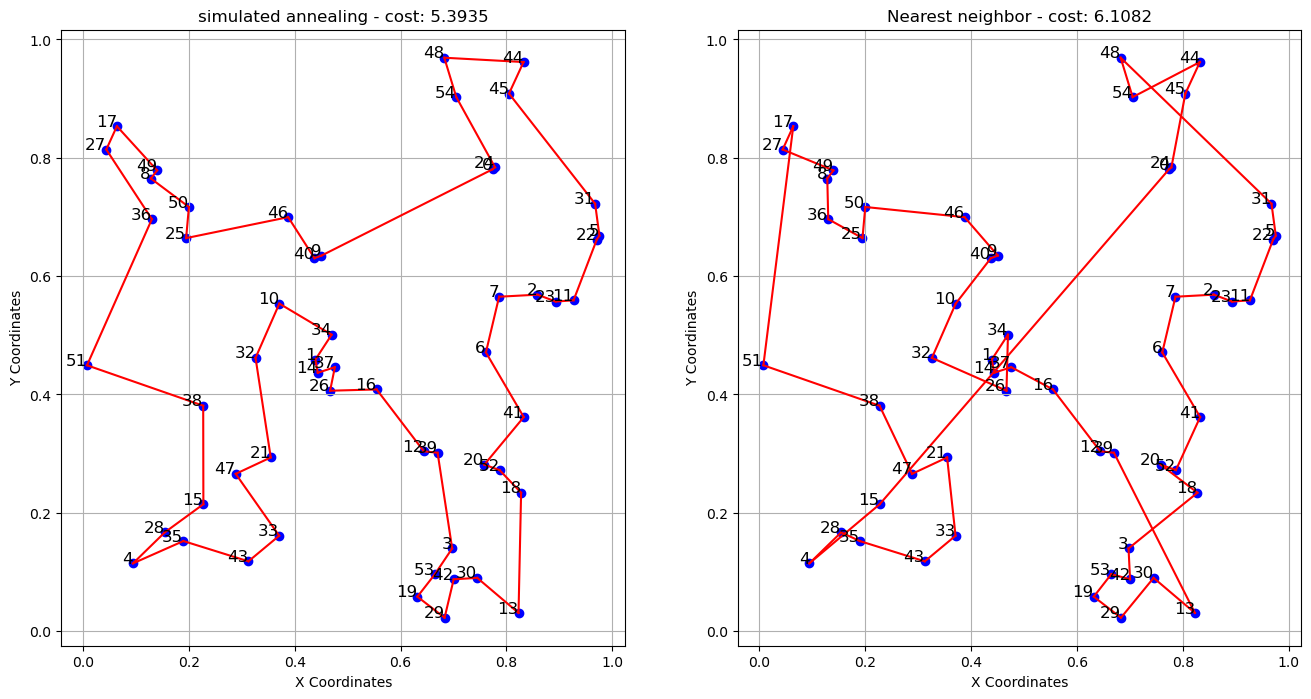

In [16]:
plot_tsp_side_by_side(x, y, 'simulated annealing', best_path, best_cost, 'Nearest neighbor', nn_path, nn_cost)

# Plotting the simulated annealing

In [17]:
def simulated_annealing_plot(
    config: dict,
    N: int,
    x: np.ndarray,
    y: np.ndarray,
    inipath: np.ndarray) -> tuple[np.array, float]:
    """
    Executes the simulated annealing algorithm in a 2d space to solve TSP.
    
    Args:
        config (dict):
            it must have the keys:
            - 'T': initial temperature,
            - 'dT': decaying temperature factor,
            - 'Tf': final minimum temperature,
            - 'steps': steps for monte carlo in the same temperature,
            - 'iterations': number of iterations of monte carlos batches,
        
        N (int): number of cities
        x (np.ndarray): x values array
        y (np.ndarray): y values array
        inipath (np.ndarray): initial path
        plot: plot the progress
        
    Returns:
        (best_path, best_cost): best path and cost encountered during the execution
    """
    
    # Initialization
    distance_matrix = distances(N, x, y)
    temp = config['T']
    
    current_path = inipath.copy()
    current_cost = -1
    
    best_path = current_path
    best_cost = np.inf
    
    # Repeat process
    for _ in range(config['iterations']):
        # Monte Carlo Simmulations
        for i in range(config['steps']):
            new_path, de = newpath(current_path, distance_matrix)
            
            if de < 0:
                current_path = new_path
                current_cost = cost(N, current_path, distance_matrix)
            else:
                if np.random.rand() <= np.exp(-de / temp):
                    current_path = new_path
                    current_cost = cost(N, current_path, distance_matrix)
                    
            if current_cost < best_cost:
                best_cost = current_cost
                best_path = current_path.copy()
            
            if i % 2 == 0:
                plot_tsp(x, y, current_path, current_cost, temp, save=True, filename=f'tsp_graph_i_{i}_t_{np.round(temp, 5)}.png')
                    
        temp = max(temp * config['dT'], config['Tf'])
    
    return best_path, best_cost

In [19]:
config['iterations'] = 50
config['steps'] = 50

simulated_annealing_plot(config, N, x, y, inipath)

(array([ 4, 35, 43, 19, 42, 30, 13, 29, 53, 33, 21, 47, 38, 10, 34, 25, 36,
        51,  8, 27, 17, 49, 50, 46, 24,  0, 31,  5, 22, 23, 11,  2,  6,  7,
        41, 12, 39, 20, 52, 18,  3, 16, 26, 37, 14,  1,  9, 54, 45, 44, 48,
        40, 32, 15, 28], dtype=int16),
 7.796243526507169)

In [13]:
# import os
# import re
# import cv2
# import numpy as np

# # Function to extract the temperature and iteration from the filename
# def extract_temp_and_iter(filename):
#     match = re.search(r"tsp_graph_i_(\d+)_t_(\d+\.\d+).png", filename)
#     if match:
#         i = int(match.group(1))
#         temp = float(match.group(2))
#         return i, temp
#     return None, None

# # Path to the directory containing the images
# image_dir = 'graphs'
# images = []

# # Read all images and their temperature and iteration values
# for file in os.listdir(image_dir):
#     if file.endswith(".png"):
#         i, temp = extract_temp_and_iter(file)
#         if i is not None and temp is not None:
#             images.append((i, temp, os.path.join(image_dir, file)))

# # Sort images first by temperature (descending) and then by iteration (ascending)
# images.sort(key=lambda x: (-x[1], x[0]))

# # Parameters for the video
# output_video = 'simulated_annealing_evolution2.mp4'
# frame_rate = 2  # frames per second

# # Read the first image to get the frame size
# first_image = cv2.imread(images[0][2])
# height, width, layers = first_image.shape

# # Define the codec and create VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# video = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))

# # Add images to the video
# for i, temp, img_path in images:
#     img = cv2.imread(img_path)
#     video.write(img)

# # Release the video writer object
# video.release()
# cv2.destroyAllWindows()

# print(f"Video saved as {output_video}")
